### Import libraries

In [9]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Customize

In [11]:
# Customize parameters
my_input_data="0904 Transaction_data.csv"
my_output_file="0904 isolation_forest_anomalies.csv"
my_plot_file="0904 isolation_forest_plot.png"
my_n_estimator=100
my_contamination=0.2
# Specify which features to use
numeric_features = ["TransactionAmount", "TransactionHour"]
categorical_features = ["MerchantCategory", "DeviceID"]  # 'Country' was dropped


### Prepare data

In [13]:
#  Load the dataset
# This file should contain fields selected 
df = pd.read_csv(my_input_data)

# Create a preprocessing pipeline
# Standardize numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Define the Isolation Forest pipeline
# contamination=0.02 assumes about 2% of the data are anomalies
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("isoforest", IsolationForest(n_estimators=my_n_estimator, contamination=my_contamination, random_state=42))
])


### Fit model and generate scores

In [15]:
# Fit the model to the data
pipeline.fit(df)

# Generate anomaly scores and predictions
# decision_function returns anomaly score: the lower, the more anomalous
df["AnomalyScore"] = pipeline.named_steps["isoforest"].decision_function(
    pipeline.named_steps["preprocessor"].transform(df)
)

# predict returns -1 for anomaly and 1 for normal; convert to Boolean
df["PredictedAnomaly"] = pipeline.named_steps["isoforest"].predict(
    pipeline.named_steps["preprocessor"].transform(df)
)
df["PredictedAnomaly"] = df["PredictedAnomaly"] == -1


### Save results and visualize 

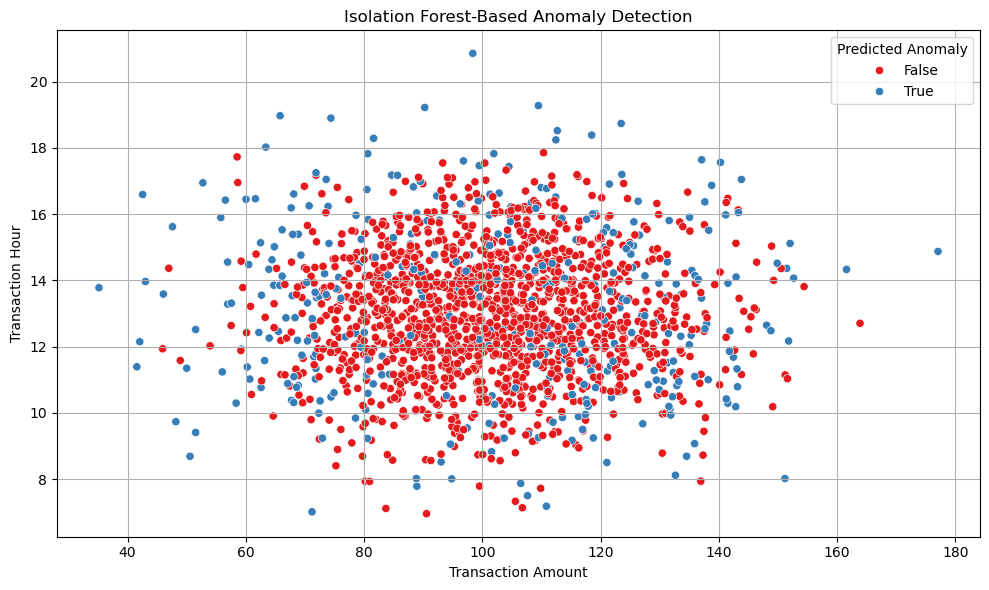

Anomalous transactions saved to: 0904 isolation_forest_plot.png


In [17]:
# Save anomalous transactions to a CSV file
df[df["PredictedAnomaly"]].to_csv(my_output_file, index=False)

# Visualize results using numeric fields (for 2D scatter)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="TransactionAmount",
    y="TransactionHour",
    hue="PredictedAnomaly",
    data=df,
    palette="Set1"
)
plt.title("Isolation Forest-Based Anomaly Detection")
plt.xlabel("Transaction Amount")
plt.ylabel("Transaction Hour")
plt.legend(title="Predicted Anomaly")
plt.grid(True)
plt.tight_layout()
plt.savefig(my_plot_file)  # Optional: save the plot
plt.show()

print(f"Anomalous transactions saved to: {my_plot_file}")
